# Predicting diabetes risk

Diabetes is an extremely common chronic disease in the United States. It's also extremely taxing on the people who have it, both physically as well as economically. Given this, it might be worth exploring whether the risk of diabetes can be predicted with data. To explore the risk factors for diabetes, I will use the Behavioral Risk Factor Surveillance System (BRFSS) from 2015.

In this notebook, I will try to accomplish the suggested research questions provided on [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv): 


1. Can survey questions from the BRFSS provide accurate predictions of whether an individual has diabetes?
2. What risk factors are most predictive of diabetes risk?
3. Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?



In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

As a crude first pass, since I am dealing with ordinal and binary data, I can look at how they are related using a Spearman correlation.

<AxesSubplot:>

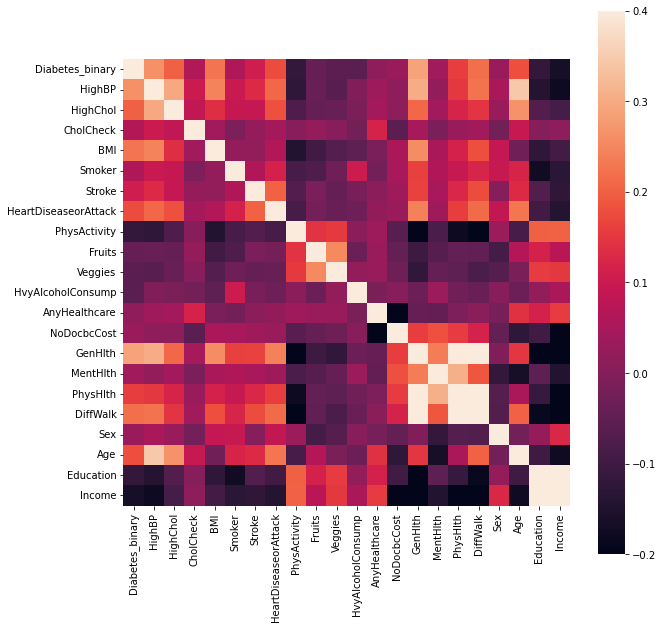

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(method='spearman'),vmin = -0.2, vmax = 0.4, square=True)

Not surprisingly, diabetes is correlated with poor health markers such as high blood pressure, BMI and cholesterol, and with poor health behaviors such as smoking and lack of exercise. However there are no variables with clear outsized importance, suggesting that the causation of diabetes is complex and multifaceted.

## 1. Can survey questions accurately predict diabetes?

Since I am predicting a category for labeled data with a relatively large number of samples, I'll try using a simple neural network

In [6]:
X = data.drop(['Diabetes_binary'],axis=1)
X_sc = MinMaxScaler().fit_transform(X)
y = data['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.20, random_state=123)

In [51]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hp.Int("input_units",32,512,32),activation='relu'))
    for i in range(hp.Int("n_layers",1,2)):
        model.add(tf.keras.layers.Dense(hp.Int(f"layer_{i}",32,512,32),activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

tuner = BayesianOptimization(
    build_model,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,
    directory = "diabetes_risk",
    overwrite=True)

tuner.search(x=X_train,y=y_train,epochs=1,batch_size=256,verbose=1,validation_split=0.33)


Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.8649137020111084

Best val_accuracy So Far: 0.8656752109527588
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit


In [56]:
print(tuner.get_best_hyperparameters()[0].values)
best_model = tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, validation_split = 0.33,epochs=6, batch_size = 256)

{'input_units': 192, 'n_layers': 2, 'layer_0': 416, 'layer_1': 32}
Epoch 1/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0980 - accuracy: 0.8651 - val_loss: 0.0988 - val_accuracy: 0.8648
Epoch 2/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0974 - accuracy: 0.8662 - val_loss: 0.0978 - val_accuracy: 0.8664
Epoch 3/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0969 - accuracy: 0.8665 - val_loss: 0.0985 - val_accuracy: 0.8662
Epoch 4/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0966 - accuracy: 0.8672 - val_loss: 0.0979 - val_accuracy: 0.8666
Epoch 5/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0962 - accuracy: 0.8680 - val_loss: 0.0976 - val_accuracy: 0.8666
Epoch 6/6
532/532 [==============================] - 2s 4ms/step - loss: 0.0960 - accuracy: 0.8682 - val_loss: 0.0974 - val_accuracy: 0.8665


Text(0.5, 0, 'Epochs')

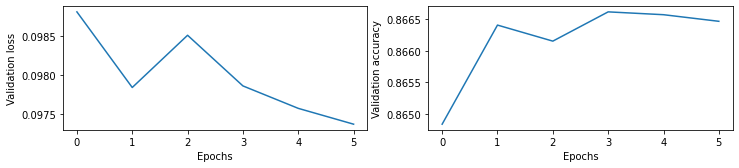

In [57]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

The accuracy determined with the validation set sits at about 0.86 for all of the epochs, which appears OK. But let's look at the confusion matrix.

Text(33.0, 0.5, 'Actual')

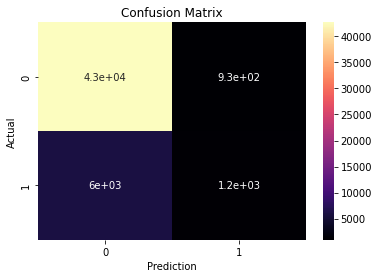

In [58]:
y_pred = best_model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,np.round(y_pred))
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

Even though the accuracy at first seems "decent", the confusion matrix is bad. There are just as many false positives as there are true positives. The chance of telling somebody that they have diabetes when they actually don't is equally likely. If we just created a model predicting that all the results were negative, what would we get?

In [36]:
np.sum(y==0)/np.size(y)

0.8606669820245979

This suggests that our fancy neural network model is not great at all, doing only 0.5% better than the most naive model imaginable. Perhaps the issue is that the model is only good at predicting true negatives, because that is usually what it sees. This is an intrinsic flaw in the input dataset, because it contains mostly negatives. To fix this, I need to rebalance it. The Kaggle page already provides this dataset, but I want to try doing it myself.

In [37]:
diabetes_group = data[data['Diabetes_binary']==1]
nodiabetes_group = data[data['Diabetes_binary']==0]
diabetes_group_oversampled = diabetes_group.sample(len(nodiabetes_group),replace=True) 

data_oversampled = pd.concat([diabetes_group_oversampled,nodiabetes_group],axis=0)

<AxesSubplot:title={'center':'After'}>

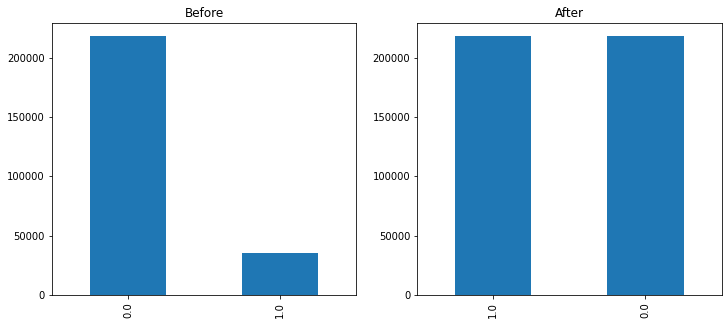

In [38]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
data['Diabetes_binary'].value_counts().plot(kind='bar',title='Before')
plt.subplot(122)
data_oversampled['Diabetes_binary'].value_counts().plot(kind='bar', title='After')

This is much better. Let's see if a neural network works better now....

In [59]:
X_os = data_oversampled.drop(['Diabetes_binary'],axis=1)
X_os_sc = MinMaxScaler().fit_transform(X_os)
y_os = data_oversampled['Diabetes_binary']
X_os_train, X_os_test, y_os_train, y_os_test =train_test_split(X_os_sc, y_os, test_size=0.20, random_state=123)

tuner_os = BayesianOptimization(
    build_model,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,
    directory = "diabetes_risk",
    overwrite=True)

In [61]:
tuner_os.search(x=X_os_train,y=y_os_train,epochs=50,batch_size=1024,validation_split=0.33)

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.8470693230628967

Best val_accuracy So Far: 0.8513545393943787
Total elapsed time: 00h 09m 12s
INFO:tensorflow:Oracle triggered exit


In [64]:
print(tuner_os.get_best_hyperparameters()[0].values)
best_model_os = tuner_os.get_best_models()[0]
history = best_model_os.fit(X_os_train, y_os_train, validation_split = 0.33,epochs=200, batch_size = 2048)

{'input_units': 416, 'n_layers': 2, 'layer_0': 512, 'layer_1': 512}
Epoch 1/200
115/115 [==============================] - 1s 7ms/step - loss: 0.0573 - accuracy: 0.9299 - val_loss: 0.1119 - val_accuracy: 0.8599
Epoch 2/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9337 - val_loss: 0.1101 - val_accuracy: 0.8640
Epoch 3/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0534 - accuracy: 0.9357 - val_loss: 0.1112 - val_accuracy: 0.8626
Epoch 4/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0528 - accuracy: 0.9363 - val_loss: 0.1104 - val_accuracy: 0.8639
Epoch 5/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0523 - accuracy: 0.9370 - val_loss: 0.1108 - val_accuracy: 0.8633
Epoch 6/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0520 - accuracy: 0.9374 - val_loss: 0.1091 - val_accuracy: 0.8658
Epoch 7/200
115/115 [==============================] - 1s 5ms/step - loss:

115/115 [==============================] - 1s 5ms/step - loss: 0.0339 - accuracy: 0.9609 - val_loss: 0.1057 - val_accuracy: 0.8776
Epoch 58/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0337 - accuracy: 0.9612 - val_loss: 0.1020 - val_accuracy: 0.8815
Epoch 59/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0331 - accuracy: 0.9618 - val_loss: 0.1020 - val_accuracy: 0.8815
Epoch 60/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0337 - accuracy: 0.9610 - val_loss: 0.1052 - val_accuracy: 0.8790
Epoch 61/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0336 - accuracy: 0.9609 - val_loss: 0.1072 - val_accuracy: 0.8761
Epoch 62/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0333 - accuracy: 0.9613 - val_loss: 0.1076 - val_accuracy: 0.8759
Epoch 63/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0331 - accuracy: 0.9616 - val_loss: 0.1062 - val_accuracy: 0.8781
Epoch

Epoch 114/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0278 - accuracy: 0.9682 - val_loss: 0.1048 - val_accuracy: 0.8816
Epoch 115/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0272 - accuracy: 0.9689 - val_loss: 0.1044 - val_accuracy: 0.8824
Epoch 116/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0272 - accuracy: 0.9690 - val_loss: 0.1005 - val_accuracy: 0.8858
Epoch 117/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0275 - accuracy: 0.9686 - val_loss: 0.1026 - val_accuracy: 0.8836
Epoch 118/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0277 - accuracy: 0.9680 - val_loss: 0.1051 - val_accuracy: 0.8814
Epoch 119/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0280 - accuracy: 0.9675 - val_loss: 0.1036 - val_accuracy: 0.8837
Epoch 120/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0274 - accuracy: 0.9686 - val_loss: 0.1010 - val_ac

115/115 [==============================] - 1s 5ms/step - loss: 0.0246 - accuracy: 0.9719 - val_loss: 0.1036 - val_accuracy: 0.8848
Epoch 171/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0249 - accuracy: 0.9716 - val_loss: 0.1060 - val_accuracy: 0.8825
Epoch 172/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0244 - accuracy: 0.9723 - val_loss: 0.1002 - val_accuracy: 0.8888
Epoch 173/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0248 - accuracy: 0.9717 - val_loss: 0.1030 - val_accuracy: 0.8852
Epoch 174/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.9715 - val_loss: 0.1065 - val_accuracy: 0.8818
Epoch 175/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.9713 - val_loss: 0.1006 - val_accuracy: 0.8879
Epoch 176/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0250 - accuracy: 0.9713 - val_loss: 0.1038 - val_accuracy: 0.8849

Text(0.5, 0, 'Epochs')

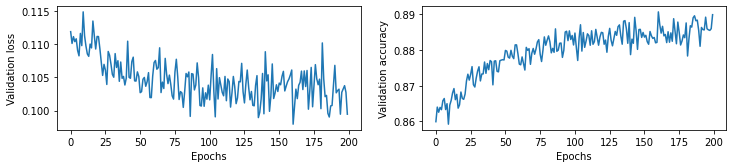

In [65]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

Text(33.0, 0.5, 'Actual')

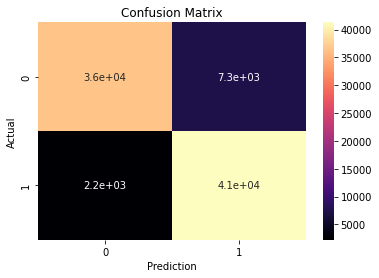

In [68]:
y_os_pred = best_model_os.predict(X_os_test)
conf_mat = metrics.confusion_matrix(y_os_test,np.round(y_os_pred))
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [73]:
test_loss, test_acc = best_model_os.evaluate(X_os_test, y_os_test)
print("Loss: %s" % test_loss)
print("Accuracy: %s" % test_acc)

2730/2730 [==============================] - 4s 2ms/step - loss: 0.0996 - accuracy: 0.8902
Loss: 0.09957309067249298
Accuracy: 0.890180230140686


This is a much better set of results. True positives and negatives are much more common than false positives and negatives. This is a much better score than the naive method used before would predict: 0.5 (since I artificially oversampled). From this, we can conclude that it is possible to predict diabetes relatively well with survey questions, provided that the dataset is over or undersampled such that the two outcomes are equally probable.

## 2. What risk factors are most predictive of diabetes risk?

There are a lot of ways I could do this. But since I am learning neural networks, let's try using a method that works with them called "permutation importance". This method tests a trained model on datasets where each feature's values are  shuffled to see how it affects the performance. By design, the method is biased toward features that are correlated, but all of the survey questions seem to imply a hypothesized correlation, so this shouldn't be a design flaw here.

I use the eli5 package to accomplish this, which is supposed to work better with sklearn models. I created a simple wrapper to get it to cooperate quickly.

In [80]:
my_model = KerasRegressor(build_fn= lambda: best_model_os)
history = my_model.fit(X_os_train, y_os_train, validation_split = 0.33,epochs=200, batch_size = 2048)

Epoch 1/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0233 - accuracy: 0.9735 - val_loss: 0.1042 - val_accuracy: 0.8849
Epoch 2/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0249 - accuracy: 0.9714 - val_loss: 0.1059 - val_accuracy: 0.8829
Epoch 3/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0237 - accuracy: 0.9730 - val_loss: 0.1015 - val_accuracy: 0.8882
Epoch 4/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0239 - accuracy: 0.9731 - val_loss: 0.1086 - val_accuracy: 0.8800
Epoch 5/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0240 - accuracy: 0.9727 - val_loss: 0.1030 - val_accuracy: 0.8862
Epoch 6/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0239 - accuracy: 0.9728 - val_loss: 0.1004 - val_accuracy: 0.8894
Epoch 7/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0246 - accuracy: 0.9721 - val_loss: 0.1029 - val_accuracy: 0.8866

Epoch 58/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0240 - accuracy: 0.9726 - val_loss: 0.1024 - val_accuracy: 0.8872
Epoch 59/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0229 - accuracy: 0.9742 - val_loss: 0.0996 - val_accuracy: 0.8906
Epoch 60/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0231 - accuracy: 0.9737 - val_loss: 0.1012 - val_accuracy: 0.8887
Epoch 61/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0229 - accuracy: 0.9739 - val_loss: 0.0983 - val_accuracy: 0.8919
Epoch 62/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0224 - accuracy: 0.9745 - val_loss: 0.1053 - val_accuracy: 0.8847
Epoch 63/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0227 - accuracy: 0.9742 - val_loss: 0.1010 - val_accuracy: 0.8891
Epoch 64/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0232 - accuracy: 0.9737 - val_loss: 0.1050 - val_accuracy:

Epoch 115/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0215 - accuracy: 0.9758 - val_loss: 0.1040 - val_accuracy: 0.8867
Epoch 116/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0219 - accuracy: 0.9752 - val_loss: 0.1023 - val_accuracy: 0.8881
Epoch 117/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0223 - accuracy: 0.9747 - val_loss: 0.1068 - val_accuracy: 0.8844
Epoch 118/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0233 - accuracy: 0.9735 - val_loss: 0.1027 - val_accuracy: 0.8881
Epoch 119/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0229 - accuracy: 0.9740 - val_loss: 0.1005 - val_accuracy: 0.8889
Epoch 120/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0232 - accuracy: 0.9735 - val_loss: 0.1034 - val_accuracy: 0.8864
Epoch 121/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0237 - accuracy: 0.9729 - val_loss: 0.0986 - val_ac

115/115 [==============================] - 1s 5ms/step - loss: 0.0218 - accuracy: 0.9754 - val_loss: 0.1008 - val_accuracy: 0.8904
Epoch 172/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0212 - accuracy: 0.9764 - val_loss: 0.1054 - val_accuracy: 0.8858
Epoch 173/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0214 - accuracy: 0.9759 - val_loss: 0.0987 - val_accuracy: 0.8931
Epoch 174/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0218 - accuracy: 0.9753 - val_loss: 0.1009 - val_accuracy: 0.8900
Epoch 175/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0217 - accuracy: 0.9757 - val_loss: 0.0974 - val_accuracy: 0.8941
Epoch 176/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0211 - accuracy: 0.9764 - val_loss: 0.0985 - val_accuracy: 0.8937
Epoch 177/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0216 - accuracy: 0.9758 - val_loss: 0.0996 - val_accuracy: 0.8918

In [81]:
perm = PermutationImportance(my_model, random_state=1).fit(X_os_test,y_os_test)
eli5.show_weights(perm, feature_names = X_os_test.columns.tolist())

2730/2730 [==============================] - 5s 2ms/step - loss: 0.2087 - accuracy: 0.7770


2730/2730 [==============================] - 4s 2ms/step - loss: 0.2467 - accuracy: 0.7365


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [82]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1770 ± 0.0022,GenHlth
0.1615 ± 0.0012,BMI
0.1575 ± 0.0017,Age
0.1454 ± 0.0024,Income
0.1236 ± 0.0011,HighBP
0.1203 ± 0.0009,HighChol
0.1117 ± 0.0008,Sex
0.1110 ± 0.0014,Education
0.1076 ± 0.0007,Smoker
0.1057 ± 0.0006,PhysHlth


The importance of each feature seems to gradually decrease; there is no obvious cutoff. This result agrees with the correlation matrix we calculated above: there were no obvious features that stood above the rest. Let's try arbitrarily cutting off the data at the point where the relatively weight is about half of the top value. We can visualize these features easily with seaborn.

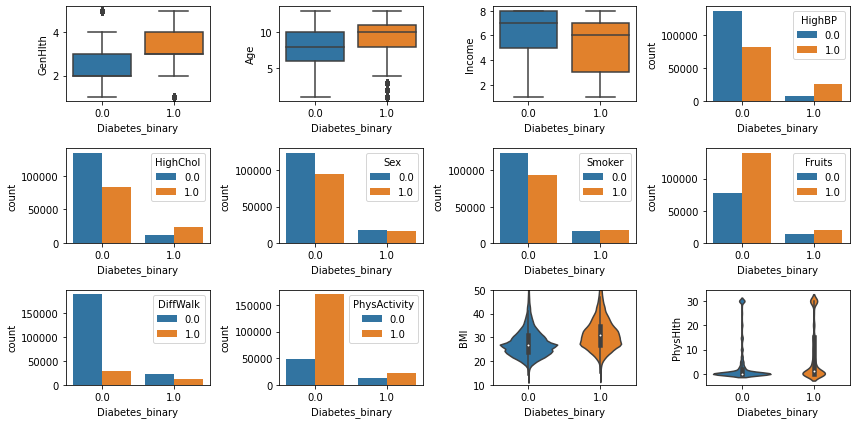

In [83]:
fig = plt.figure(figsize=(12,6))




for i,name in enumerate(['GenHlth','Age','Income']):
    plt.subplot(3,4,i+1)
    sns.boxplot(data=data,x='Diabetes_binary',y=name)

for i,name in enumerate(['HighBP','HighChol','Sex','Smoker','Fruits','DiffWalk','PhysActivity']):
    plt.subplot(3,4,i+4)
    sns.countplot(data=data,x='Diabetes_binary',hue=name)

plt.subplot(3,4,11)
sns.violinplot(data=data,x='Diabetes_binary',y='BMI')
plt.ylim(10,50)
plt.subplot(3,4,12)
sns.violinplot(data=data,x='Diabetes_binary',y='PhysHlth')
    
plt.tight_layout()


## 3. Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?

Let's see if I can get a decent model working with only the top 12 risk factors.

In [88]:
X_sub = X_os[['HighBP','BMI','GenHlth','Age','Income','HighChol','Sex','PhysHlth','Smoker','Fruits','DiffWalk','PhysActivity']]
X_sub_sc = MinMaxScaler().fit_transform(X_sub)
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub_sc, y_os, test_size=0.20, random_state=123)

In [89]:
tuner_sub = BayesianOptimization(
    build_model,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,
    directory = "diabetes_risk",
    overwrite=True)
tuner_sub.search(x=X_sub_train,y=y_sub_train,epochs=150,batch_size=2048,verbose=1,validation_split=0.33)

Trial 10 Complete [00h 01m 34s]
val_accuracy: 0.8372498750686646

Best val_accuracy So Far: 0.8397220969200134
Total elapsed time: 00h 13m 38s
INFO:tensorflow:Oracle triggered exit


In [90]:
print(tuner_sub.get_best_hyperparameters()[0].values)
best_model_sub = tuner_sub.get_best_models()[0]
history = best_model_sub.fit(X_sub_train, y_sub_train, validation_split = 0.33,epochs=200, batch_size = 2048)

{'input_units': 512, 'n_layers': 2, 'layer_0': 512, 'layer_1': 512}
Epoch 1/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0759 - accuracy: 0.9022 - val_loss: 0.1276 - val_accuracy: 0.8371
Epoch 2/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0747 - accuracy: 0.9041 - val_loss: 0.1276 - val_accuracy: 0.8359
Epoch 3/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9031 - val_loss: 0.1289 - val_accuracy: 0.8354
Epoch 4/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9047 - val_loss: 0.1311 - val_accuracy: 0.8351
Epoch 5/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0748 - accuracy: 0.9040 - val_loss: 0.1285 - val_accuracy: 0.8375
Epoch 6/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0742 - accuracy: 0.9050 - val_loss: 0.1270 - val_accuracy: 0.8378
Epoch 7/200
115/115 [==============================] - 1s 6ms/step - loss:

115/115 [==============================] - 1s 5ms/step - loss: 0.0640 - accuracy: 0.9194 - val_loss: 0.1237 - val_accuracy: 0.8465
Epoch 58/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0644 - accuracy: 0.9186 - val_loss: 0.1264 - val_accuracy: 0.8438
Epoch 59/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0653 - accuracy: 0.9172 - val_loss: 0.1282 - val_accuracy: 0.8429
Epoch 60/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0644 - accuracy: 0.9188 - val_loss: 0.1232 - val_accuracy: 0.8479
Epoch 61/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9203 - val_loss: 0.1253 - val_accuracy: 0.8467
Epoch 62/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0639 - accuracy: 0.9197 - val_loss: 0.1230 - val_accuracy: 0.8485
Epoch 63/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0637 - accuracy: 0.9195 - val_loss: 0.1220 - val_accuracy: 0.8492
Epoch

Epoch 114/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0591 - accuracy: 0.9263 - val_loss: 0.1220 - val_accuracy: 0.8516
Epoch 115/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0585 - accuracy: 0.9273 - val_loss: 0.1223 - val_accuracy: 0.8523
Epoch 116/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0592 - accuracy: 0.9255 - val_loss: 0.1194 - val_accuracy: 0.8552
Epoch 117/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0581 - accuracy: 0.9276 - val_loss: 0.1234 - val_accuracy: 0.8511
Epoch 118/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0585 - accuracy: 0.9268 - val_loss: 0.1237 - val_accuracy: 0.8514
Epoch 119/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0583 - accuracy: 0.9271 - val_loss: 0.1256 - val_accuracy: 0.8483
Epoch 120/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0586 - accuracy: 0.9265 - val_loss: 0.1229 - val_ac

115/115 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9321 - val_loss: 0.1217 - val_accuracy: 0.8547
Epoch 171/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9322 - val_loss: 0.1224 - val_accuracy: 0.8542
Epoch 172/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0543 - accuracy: 0.9328 - val_loss: 0.1186 - val_accuracy: 0.8590
Epoch 173/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0550 - accuracy: 0.9314 - val_loss: 0.1240 - val_accuracy: 0.8504
Epoch 174/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0557 - accuracy: 0.9302 - val_loss: 0.1228 - val_accuracy: 0.8543
Epoch 175/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0554 - accuracy: 0.9309 - val_loss: 0.1192 - val_accuracy: 0.8571
Epoch 176/200
115/115 [==============================] - 1s 5ms/step - loss: 0.0556 - accuracy: 0.9304 - val_loss: 0.1197 - val_accuracy: 0.8568

Text(0.5, 0, 'Epochs')

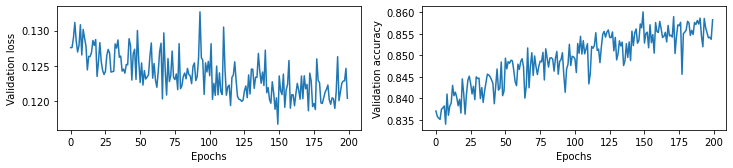

In [91]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

Text(33.0, 0.5, 'Actual')

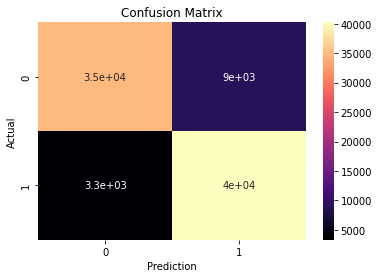

In [94]:
y_sub_pred = best_model_sub.predict(X_sub_test)
conf_mat = metrics.confusion_matrix(y_sub_test,np.round(y_sub_pred))
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [96]:
test_loss, test_acc = best_model_sub.evaluate(X_sub_test, y_sub_test)
print("Loss: %s" % test_loss)
print("Accuracy: %s" % test_acc)

2730/2730 [==============================] - 5s 2ms/step - loss: 0.1198 - accuracy: 0.8588
Loss: 0.11979702860116959
Accuracy: 0.8588064312934875


Using half the features, we can get a model with about 86% accuracy. The accuracy decreased by about 3%, which is not bad, considering that the features we removed had significant weight values. 